# Etudes


## Convert Photosphere to Cubemap
http://stackoverflow.com/questions/29678510/convert-21-equirectangular-panorama-to-cube-map

Sample Photos

Exterior Shot:
![ExteriorBuckminsterFuller](images/IMG_20170408_131933.jpg)

Photosphere:
![PhotosphereBuckminsterFuller](images/PANO_20170408_132436.jpg)

Unity by default needs the cubemap plus on the left side of image.


In [11]:
%time print("hello")


hello
CPU times: user 267 µs, sys: 258 µs, total: 525 µs
Wall time: 357 µs


In [12]:
%%time

## Convert photosphere to cubemap
	
from matplotlib.pyplot import imshow
import numpy as np
from PIL import Image
from math import pi,sin,cos,tan, atan2
%matplotlib inline

def cot(angle):
    return 1/tan(angle)

# Project polar coordinates onto a surrounding cube
# assume ranges theta is [0,pi] with 0 the north poll, pi south poll
# phi is in range [0,2pi] 
def projection(theta,phi): 
        if theta<0.615:
            return projectTop(theta,phi)
        elif theta>2.527:
            return projectBottom(theta,phi)
        elif phi <= pi/4 or phi > 7*pi/4:
            return projectLeft(theta,phi)
        elif phi > pi/4 and phi <= 3*pi/4:
            return projectFront(theta,phi)
        elif phi > 3*pi/4 and phi <= 5*pi/4:
            return projectRight(theta,phi)
        elif phi > 5*pi/4 and phi <= 7*pi/4:
            return projectBack(theta,phi)

def projectLeft(theta,phi):
        x = 1
        y = tan(phi)
        z = cot(theta) / cos(phi)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Left",x,y,z)

def projectFront(theta,phi):
        x = tan(phi-pi/2)
        y = 1
        z = cot(theta) / cos(phi-pi/2)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Front",x,y,z)

def projectRight(theta,phi):
        x = -1
        y = tan(phi)
        z = -cot(theta) / cos(phi)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Right",x,-y,z)

def projectBack(theta,phi):
        x = tan(phi-3*pi/2)
        y = -1
        z = cot(theta) / cos(phi-3*pi/2)
        if z < -1:
            return projectBottom(theta,phi)
        if z > 1:
            return projectTop(theta,phi)
        return ("Back",-x,y,z)

def projectTop(theta,phi):
        # (a sin θ cos ø, a sin θ sin ø, a cos θ) = (x,y,1)
        a = 1 / cos(theta)
        x = tan(theta) * cos(phi)
        y = tan(theta) * sin(phi)
        z = 1
        return ("Top",x,y,z)

def projectBottom(theta,phi):
        # (a sin θ cos ø, a sin θ sin ø, a cos θ) = (x,y,-1)
        a = -1 / cos(theta)
        x = -tan(theta) * cos(phi)
        y = -tan(theta) * sin(phi)
        z = -1
        return ("Bottom",x,y,z)

# Convert coords in cube to image coords 
# coords is a tuple with the side and x,y,z coords
# edge is the length of an edge of the cube in pixels
def cubeToImg(coords,edge):
    if coords[0]=="Left":
        (x,y) = (int(edge*(coords[2]+1)/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Front":
        (x,y) = (int(edge*(coords[1]+3)/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Right":
        (x,y) = (int(edge*(5-coords[2])/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Back":
        (x,y) = (int(edge*(7-coords[1])/2), int(edge*(3-coords[3])/2) )
    elif coords[0]=="Top":
        (x,y) = (int(edge*(3-coords[1])/2), int(edge*(1+coords[2])/2) )
    elif coords[0]=="Bottom":
        (x,y) = (int(edge*(3-coords[1])/2), int(edge*(5-coords[2])/2) )
    return (x,y)

# convert the in image to out image
def convert(imgIn,imgOut):
    inSize = imgIn.size
    outSize = imgOut.size
    inPix = imgIn.load()
    outPix = imgOut.load()
    edge = inSize[0]/4   # the length of each edge in pixels
    for i in range(inSize[0]):
        for j in range(inSize[1]):
            pixel = inPix[i,j]
            phi = i * 2 * pi / inSize[0]
            theta = j * pi / inSize[1]
            res = projection(theta,phi)
            (x,y) = cubeToImg(res,edge)
            #if i % 100 == 0 and j % 100 == 0:
            #   print i,j,phi,theta,res,x,y
            if x >= outSize[0]:
                #print "x out of range ",x,res
                x=outSize[0]-1
            if y >= outSize[1]:
                #print "y out of range ",y,res
                y=outSize[1]-1
            outPix[x,y] = pixel



CPU times: user 4.5 ms, sys: 1.91 ms, total: 6.41 ms
Wall time: 7.18 ms


In [13]:
%%time

from PIL import Image
from math import pi,sin,cos,tan,atan2,hypot,floor
from numpy import clip

# get x,y,z coords from out image pixels coords
# i,j are pixel coords
# face is face number
# edge is edge length
def outImgToXYZ(i,j,face,edge):
    a = 2.0*float(i)/edge
    b = 2.0*float(j)/edge
    if face==0: # back
        (x,y,z) = (-1.0, 1.0-a, 3.0 - b)
    elif face==1: # left
        (x,y,z) = (a-3.0, -1.0, 3.0 - b)
    elif face==2: # front
        (x,y,z) = (1.0, a - 5.0, 3.0 - b)
    elif face==3: # right
        (x,y,z) = (7.0-a, 1.0, 3.0 - b)
    elif face==4: # top
        (x,y,z) = (b-1.0, a -5.0, 1.0)
    elif face==5: # bottom
        (x,y,z) = (5.0-b, a-5.0, -1.0)
    return (x,y,z)

# convert using an inverse transformation
def convertBack(imgIn,imgOut):
    inSize = imgIn.size
    outSize = imgOut.size
    inPix = imgIn.load()
    outPix = imgOut.load()
    edge = int(inSize[0]/4)   # the length of each edge in pixels
    for i in range(outSize[0]):
        face = int(i/edge) # 0 - back, 1 - left 2 - front, 3 - right
        if face==2:
            rng = range(0,edge*3)
        else:
            rng = range(edge,edge*2)

        for j in rng:
            if j<edge:
                face2 = 4 # top
            elif j>=2*edge:
                face2 = 5 # bottom
            else:
                face2 = face

            (x,y,z) = outImgToXYZ(i,j,face2,edge)
            theta = atan2(y,x) # range -pi to pi
            r = hypot(x,y)
            phi = atan2(z,r) # range -pi/2 to pi/2
            # source img coords
            uf = ( 2.0*edge*(theta + pi)/pi )
            vf = ( 2.0*edge * (pi/2 - phi)/pi)
            # Use bilinear interpolation between the four surrounding pixels
            ui = floor(uf)  # coord of pixel to bottom left
            vi = floor(vf)
            u2 = ui+1       # coords of pixel to top right
            v2 = vi+1
            mu = uf-ui      # fraction of way across pixel
            nu = vf-vi
            # Pixel values of four corners
            A = inPix[ui % inSize[0],int(clip(vi,0,inSize[1]-1))]
            B = inPix[u2 % inSize[0],int(clip(vi,0,inSize[1]-1))]
            C = inPix[ui % inSize[0],int(clip(v2,0,inSize[1]-1))]
            D = inPix[u2 % inSize[0],int(clip(v2,0,inSize[1]-1))]
            # interpolate
            (r,g,b) = (
              A[0]*(1-mu)*(1-nu) + B[0]*(mu)*(1-nu) + C[0]*(1-mu)*nu+D[0]*mu*nu,
              A[1]*(1-mu)*(1-nu) + B[1]*(mu)*(1-nu) + C[1]*(1-mu)*nu+D[1]*mu*nu,
              A[2]*(1-mu)*(1-nu) + B[2]*(mu)*(1-nu) + C[2]*(1-mu)*nu+D[2]*mu*nu )

            outPix[i,j] = (int(round(r)),int(round(g)),int(round(b)))



CPU times: user 29 µs, sys: 1 µs, total: 30 µs
Wall time: 33.1 µs


start1
end1
CPU times: user 1min 59s, sys: 605 ms, total: 2min
Wall time: 2min


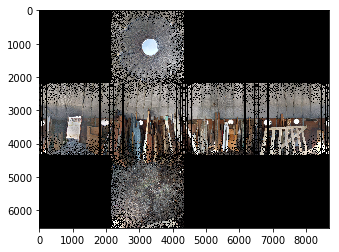

In [14]:
%%time
## Example
print("start1")
imgIn = Image.open("images/PANO_20170408_132436.jpg")
inSize = imgIn.size
imgOut = Image.new("RGB",(inSize[0],int(inSize[0]*3/4)),"black")
convert(imgIn,imgOut)
imgOut.save("images/out1.jpg")
imshow(np.asarray(imgOut))
print("end1")


imgIn original size: (8704, 4352)
scale factor:  4.25
Scaled Down: (2048, 1024)
imgScaled size:  (2048, 1024)
CPU times: user 1min 11s, sys: 728 ms, total: 1min 12s
Wall time: 1min 12s


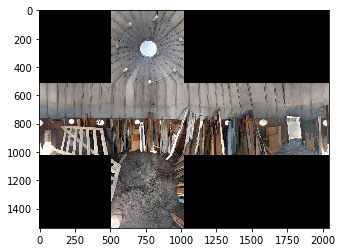

In [28]:
%%time
imgIn = Image.open("images/PANO_20170408_132436.jpg")
#This file is too large for Seond Life only 2048 can be used
#Since we want to save time. The full image takes about 20 minutes. Let's scale it here.
inSize = imgIn.size
print("imgIn original size:", imgIn.size)
scalefactor = imgIn.size[0]/2048
print("scale factor: ", scalefactor)
inSize = (int(inSize[0]//scalefactor), int(inSize[1]//scalefactor))
print("Scaled Down:",inSize)

#scale down
imgScaled = imgIn.resize(inSize, Image.ANTIALIAS)
print("imgScaled size: ", imgScaled.size )
#create new image same size
imgOut = Image.new("RGB",(inSize[0],int(inSize[0]*3/4)),"black")

convertBack(imgScaled,imgOut)
imgOut = imgOut.transpose(Image.FLIP_LEFT_RIGHT)
imgOut.save("images/out4.png")
imgOut.show()
imshow(np.asarray(imgOut))


In [16]:
%time print("hello")


hello
CPU times: user 352 µs, sys: 276 µs, total: 628 µs
Wall time: 455 µs


# https://github.com/dankex/compv/blob/master/3d-graphics/skybox/cubemap-cut.py

```python
#!/usr/bin/python

from __future__ import print_function
import sys
import os.path
from PIL import Image
import zipfile

if len(sys.argv) < 2:
    print("Usage: cubemap-cut.py <filename.jpg|png>")
    sys.exit(-1)

infile = sys.argv[1]
filename, original_extension = os.path.splitext(infile)
file_extension = ".png"

name_map = [ \
     ["", "", "posy", ""],
     ["negz", "negx", "posz", "posx"],
     ["", "", "negy", ""]]

try:
    im = Image.open(infile)
    print(infile, im.format, "%dx%d" % im.size, im.mode)

    width, height = im.size

    cube_size = width / 4

    filelist = []
    for row in range(3):
        for col in range(4):
            if name_map[row][col] != "":
                sx = cube_size * col
                sy = cube_size * row
                fn = name_map[row][col] + file_extension
                filelist.append(fn)
                print("%s --> %s" % (str((sx, sy, sx + cube_size, sy + cube_size)), fn))
                im.crop((sx, sy, sx + cube_size, sy + cube_size)).save(fn) 

    zfname = filename + '.zip'
    print("Creating zipfile: " + zfname)
    zf = zipfile.ZipFile(zfname, mode='w')
    try:
        for fn in filelist:
            zf.write(fn)
        print("done")
    finally:
        zf.close()

except IOError:
    pass


```

## Quick Flop of image instead of flip

```convert -flop  Out3.png FullerFlopOut3.jpg```

In [24]:
%%time
import sys
import os.path
import zipfile

 
infile = "images/out1.jpg"
filename, original_extension = os.path.splitext(infile)
file_extension = ".jpg"

name_map = [ ["", "", "posy", ""],
     ["negz", "negx", "posz", "posx"],
     ["", "", "negy", ""]]

im = Image.open(infile)
print(infile, im.format, "%dx%d" % im.size, im.mode)

width, height = im.size

cube_size = width / 4

filelist = []
for row in range(3):
    for col in range(4):
        if name_map[row][col] != "":
            sx = cube_size * col
            sy = cube_size * row
            fn = name_map[row][col] + file_extension
            filelist.append(fn)
            print("%s --> %s" % (str((sx, sy, sx + cube_size, sy + cube_size)), fn))
            im.crop((sx, sy, sx + cube_size, sy + cube_size)).save(fn) 

zfname = filename + '.zip'
print("Creating zipfile: " + zfname)
zf = zipfile.ZipFile(zfname, mode='w')
try:
    for fn in filelist:
        zf.write(fn)
    print("done")
finally:
    zf.close()



images/out1.jpg JPEG 8704x6528 RGB
(4352.0, 0.0, 6528.0, 2176.0) --> posy.jpg
(0.0, 2176.0, 2176.0, 4352.0) --> negz.jpg
(2176.0, 2176.0, 4352.0, 4352.0) --> negx.jpg
(4352.0, 2176.0, 6528.0, 4352.0) --> posz.jpg
(6528.0, 2176.0, 8704.0, 4352.0) --> posx.jpg
(4352.0, 4352.0, 6528.0, 6528.0) --> negy.jpg
Creating zipfile: images/out1.zip
done
CPU times: user 3.39 s, sys: 91 ms, total: 3.49 s
Wall time: 3.49 s
